<a href="https://colab.research.google.com/github/AugustoBonifacio001/AugustoBonifacio001/blob/main/itera%C3%A7%C3%A3o_com_c%C3%A1lculos_do_PRD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit


def cosamp(Phi, u, s, tol=1e-10, max_iter=10):
    max_iter -= 1
    num_precision = 1e-12
    a = np.zeros(Phi.shape[1])
    v = u
    iter_count = 0
    halt = False
    while not halt:
        iter_count += 1
        y = np.abs(np.dot(np.transpose(Phi), v))
        Omega = [i for (i, val) in enumerate(y) if val > np.sort(y)[::-1][2 * s] and val > num_precision]
        T = np.union1d(Omega, a.nonzero()[0])
        b = np.dot(np.linalg.pinv(Phi[:, T]), u)
        igood = (np.abs(b) > np.sort(np.abs(b))[::-1][s]) & (np.abs(b) > num_precision)
        T = T[igood]
        a[T] = b[igood]
        v = u - np.dot(Phi[:, T], b[igood])
        halt = np.linalg.norm(v) / np.linalg.norm(u) < tol or iter_count > max_iter
    return a


def omp(Phi, u, s):
    omp_model = OrthogonalMatchingPursuit(n_nonzero_coefs=s)
    omp_model.fit(Phi, u)
    return omp_model.coef_


def calculate_mse(original, reconstructed):
    return 100 * np.sqrt(np.sum((original - reconstructed) ** 2) / np.sum((original) ** 2))


n = 6 * 128
f1 = 60
f2 = 180

x = np.sin(2 * np.pi * f1 * np.linspace(0.0, 0.1, num=n)) + 0.3 * np.sin(2 * np.pi * f2 * np.linspace(0.0, 0.1, num=n))

media_ruido = 0
desvio_padrao_ruido = np.sqrt(np.var(x) / (10 ** (40 / 10)))
ruido_gaussiano = np.random.normal(media_ruido, desvio_padrao_ruido, len(x))
x_com_ruido = x + ruido_gaussiano

lista = [10,30,50,70,90]
for CR in lista:
    p = np.abs(np.round(n - (n * CR ) / 100).astype(int))
    amostras_aleatorias = np.round((n - 1) * np.random.rand(p)).astype(int)
    y = x_com_ruido[amostras_aleatorias]

    Phi = np.fft.fft(np.eye(n, n))
    CPhi = np.imag(Phi[amostras_aleatorias, :])

    # Executar o algoritmo CoSaMP
    s_reconstruido_cosamp = cosamp(CPhi, y, 10)
    x_rec_cosamp = np.imag(np.fft.fft(s_reconstruido_cosamp))

    # Calcular erro de reconstrução
    mse_cosamp = calculate_mse(x_com_ruido, x_rec_cosamp)

    # Imprimir PRD do CoSaMP
    print(f"PRD (CoSaMP) para CR = {CR}: {mse_cosamp:.4f}")

    # Executar o algoritmo OMP
    s_reconstruido_omp = omp(CPhi, y, 10)
    x_rec_omp = np.imag(np.fft.fft(s_reconstruido_omp))

    # Calcular erro de reconstrução
    mse_omp = calculate_mse(x_com_ruido, x_rec_omp)

    # Imprimir PRD do OMP
    print(f"PRD (OMP) para CR = {CR}: {mse_omp:.4f}")


PRD (CoSaMP) para CR = 10: 3.5832
PRD (OMP) para CR = 10: 3.5543
PRD (CoSaMP) para CR = 30: 3.5926
PRD (OMP) para CR = 30: 3.5008
PRD (CoSaMP) para CR = 50: 3.5883
PRD (OMP) para CR = 50: 3.5821
PRD (CoSaMP) para CR = 70: 3.7665
PRD (OMP) para CR = 70: 4.0014
PRD (CoSaMP) para CR = 90: 12.0991
PRD (OMP) para CR = 90: 4.6784


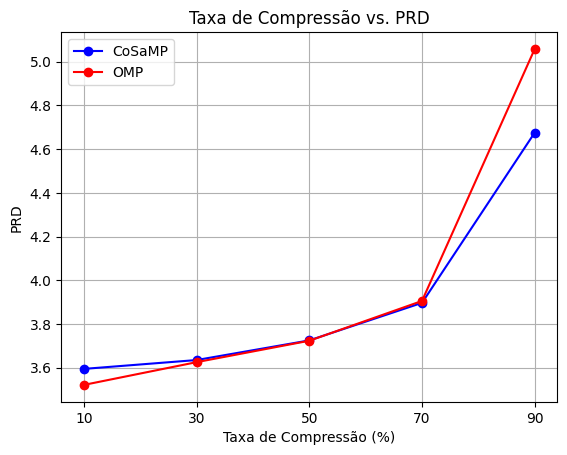

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Valores fornecidos
CR_values = [10, 30, 50, 70, 90]
PRD_cosamp_values = [3.5946, 3.6351, 3.7250, 3.8967, 4.6757]
PRD_omp_values = [3.5213, 3.6254, 3.7234, 3.9055, 5.0585]

# Plotando os valores de PRD para CoSaMP
plt.plot(CR_values, PRD_cosamp_values, marker='o', color='blue', label='CoSaMP')

# Plotando os valores de PRD para OMP
plt.plot(CR_values, PRD_omp_values, marker='o', color='red', label='OMP')

# Configurações do gráfico
plt.title('Taxa de Compressão vs. PRD')
plt.xlabel('Taxa de Compressão (%)')
plt.ylabel('PRD')
plt.xticks(CR_values)  # Definindo os valores do eixo x
plt.grid(True)
plt.legend()

# Exibindo o gráfico
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct

def sl0(A, x, sigma_min, sigma_decrease_factor=0.5, mu_0=2, L=3, A_pinv=None, true_s=None):
    if A_pinv is None:
        A_pinv = np.linalg.pinv(A)

    s = np.dot(A_pinv, x)
    sigma = 2.0 * np.abs(s).max()

    while sigma > sigma_min:
        for i in range(L):
            delta = delta_fn(s, sigma)
            s = s - mu_0 * delta
            s = s - np.dot(A_pinv, (np.dot(A, s) - x))

        sigma *= sigma_decrease_factor

    return s

def delta_fn(s, sigma):
    return s * np.exp(-np.abs(s)**2 / sigma**2)

def calculate_mse(original, reconstructed):
    return 100 * np.sqrt(np.sum((original - reconstructed) ** 2) / np.sum((original) ** 2))


n = 6 * 128
t = np.linspace(0.0, 0.1, num=n)
f1 = 60
f2 = 180

x = np.sin(2 * np.pi * f1 * t) + 0.3 * np.sin(2 * np.pi * f2 * t)
# Adicionar ruído gaussiano ao sinal original
media_ruido = 0
desvio_padrao_ruido = np.sqrt(np.var(x) / (10 ** (40 / 10)))  # Conversão de dB para magnitude do ruído
ruido_gaussiano = np.random.normal(media_ruido, desvio_padrao_ruido, len(x))
x_com_ruido = x + ruido_gaussiano

lista_cr = [10, 30, 50, 70, 90]

for CR in lista_cr:
    p = np.abs(np.round(n -(n*CR) / 100)).astype(int)

    amostras_aleatorias = np.round((n - 1) * np.random.rand(p)).astype(int)
    y = x_com_ruido[amostras_aleatorias]

    Phi = np.fft.fft(np.eye(n, n))
    CPhi = (Phi[amostras_aleatorias, :])

    # Executar o algoritmo SL0
    x_hat_sl0 = sl0(CPhi, y, sigma_min=1e-2)
    s_reconstruido_sl0 = np.real(np.fft.fft(x_hat_sl0))
    mse_sl0 = calculate_mse(x_com_ruido, s_reconstruido_sl0)

    print(f"PRD (SL0) para CR = {CR}: {mse_sl0:.4f}")



PRD (SL0) para CR = 10: 1.2496
PRD (SL0) para CR = 30: 1.4335
PRD (SL0) para CR = 50: 1.6106
PRD (SL0) para CR = 70: 1.9047
PRD (SL0) para CR = 90: 20.1554


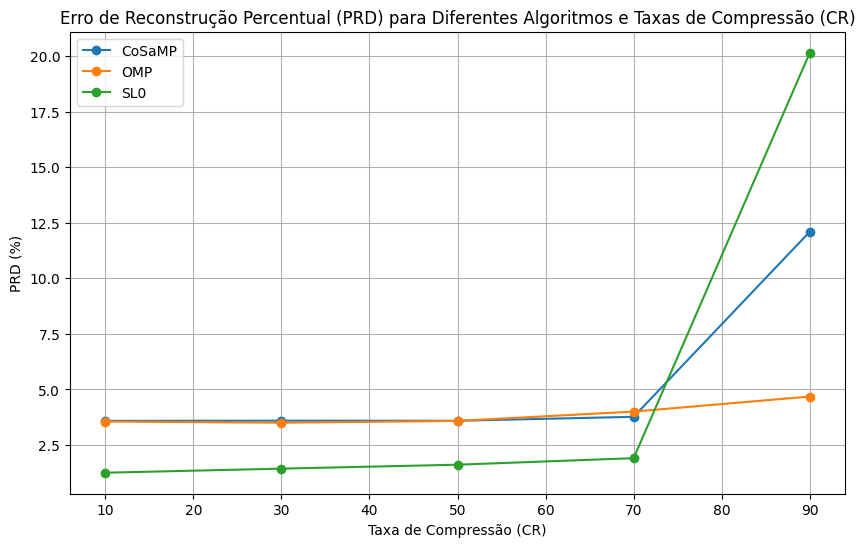

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Resultados dos PRD para CoSaMP, OMP e SL0 em diferentes CR
resultados_cosamp = [3.5832, 3.5926, 3.5883, 3.7665, 12.0991]
resultados_omp = [3.5543, 3.5008, 3.5821, 4.0014, 4.6784]
resultados_sl0 = [1.2496, 1.4335, 1.6106, 1.9047, 20.1554]

# Taxas de compressão (CR)
lista_cr = [10, 30, 50, 70, 90]

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(lista_cr, resultados_cosamp, marker='o', label='CoSaMP')
plt.plot(lista_cr, resultados_omp, marker='o', label='OMP')
plt.plot(lista_cr, resultados_sl0, marker='o', label='SL0')
plt.xlabel('Taxa de Compressão (CR)')
plt.ylabel('PRD (%)')
plt.title('Erro de Reconstrução Percentual (PRD) para Diferentes Algoritmos e Taxas de Compressão (CR)')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt

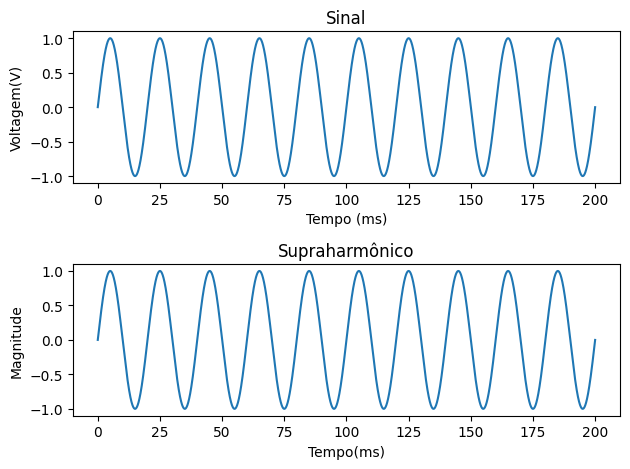

In [10]:
FreqFund = 50
Npc = 20480
Nc = 10
Npt = Nc*Npc
Fs = Npc*FreqFund #frequência de amostragem
T = 1/Fs

t = np.arange(0, Npt)*T

suprahar = []

for i in range(10):
  sinal = np.sin(2*np.pi*FreqFund*t)
  suprahar.append(sinal)

suprahar = np.array(suprahar)
np.save('suprahar1.npy', suprahar)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t*1000, suprahar[0])
plt.title("Sinal")
plt.xlabel("Tempo (ms)")
plt.ylabel("Voltagem(V)")
plt.subplot(2,1,2)
plt.plot(t*1000, suprahar[1])
plt.title("Supraharmônico")
plt.xlabel("Tempo(ms)")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()


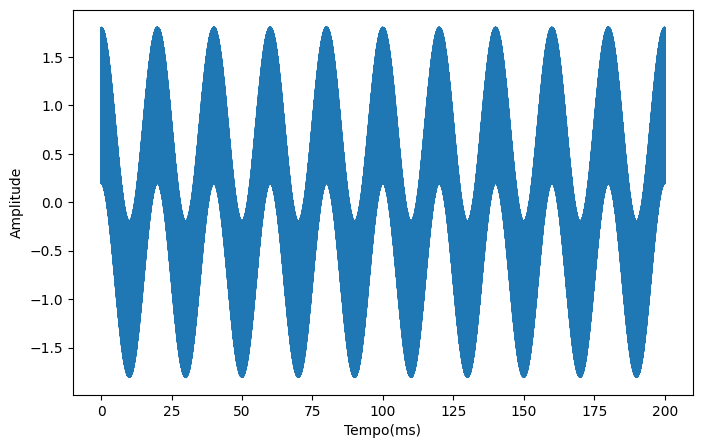

In [19]:
import numpy as np

def gera_suprahar(SNRdb, FreqFund, Vm1, Npc):
  Nc= 10
  Npt = Nc*Npc
  Fs = Npc*FreqFund
  T = 1/Fs

  t= np.arange(0, Npt)*T

  Ps = ((Vm1)**2)/2
  Pr = Ps/(10**(SNRdb/10))

  desvio = np.sqrt(Pr)
  R = np.random.normal(0, desvio, Npt)
  R = R - np.mean(R)

  x1 = Vm1*np.sin(2*np.pi*FreqFund*t + np.pi/2)

  xIn = x1 + R

  amp1 = 0.8
  fsupra = 31e3
  sh1 = amp1*np.sin(2*np.pi*fsupra*t)

  sh = sh1#sinal contaminado

  sinal = xIn + sh
  return sinal, sh

#parâmetros:

SNRdb = 50
FreqFund = 50
Vm1 = 1
Npc = 20480

sinal, sh = gera_suprahar(SNRdb, FreqFund, Vm1, Npc)

#plotagem:

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))

plt.plot(t*1000, sinal)

plt.xlabel("Tempo(ms)")
plt.ylabel("Amplitude")
plt.show()







